In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import linalg
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, chi2
from sklearn.covariance import MinCovDet

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)
warnings.filterwarnings('ignore')

In [3]:
def plotCorrelation(df):
    """ Wrapper to plot correlation of 1 variable against many """
    fig, (ax1, ax2) = plt.subplots(1, 2)
    df = df.loc[df.index != df['feature1']]
    sns.heatmap(pd.DataFrame(df['R']), yticklabels=1, 
                cmap='bwr', vmin=-1, vmax=1, ax=ax1)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.tick_params(left=True)
    sns.heatmap(pd.DataFrame(df['p']), yticklabels=1, 
                cmap='viridis', vmin=0, vmax=1, ax=ax2)
    ax2.tick_params(left=True)
    ax2.set_ylabel('')
    fig.tight_layout()
    return fig, (ax1, ax2)

In [4]:
def pearsonr_pval(x,y):
    try:
        return pearsonr(x,y)[1]
    except ValueError:
        return np.nan

In [5]:
def countPair(x, y):
    """ Return count of valid pairs (both not nan) """

    # Indices where both x and y are NOT np.nan
    validIndices = np.intersect1d(
        np.where(~np.isnan(x)),
        np.where(~np.isnan(y)))
    return len(validIndices)

In [6]:
def mahalanobis(data):
    """ Compute Mahalanobis Distance between 
        each row of data with the data. """  
    x_minus_mu = data - np.mean(data)
    cov = np.cov(data.values.T)
    inv_covmat = linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [7]:
def plotBivariateOutlier(x, y, data, threshold=0.01):
    """ Plot scatter with indexes of outliers labelled """
    sub = data[[x, y]]
    sub['mahalanobis'] = mahalanobis(sub)
    sub['outlier'] = subX['mahalanobis'] > chi2.ppf((1 - threshold), df=2)
    fig, ax = plt.subplots(1)
    sns.scatterplot(x=x, y=y, hue='outlier', data=sub, ax=ax)
    for outlier in subX[subX['outlier']].index:
        ax.text(subX.loc[outlier, 'SalePrice'], subX.loc[outlier, 'GrLivArea'], outlier)
    fig.tight_layout()
    return fig, ax

In [8]:
def plotDistribution(x):
    """ Wrapper to plot univariate distribution 
        and probability plot"""
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.distplot(x, ax=ax1)
    ax1.set_title(f'Skewness = {x.skew():.2f}; Kurtosis = {x.kurtosis():.2f}')
    stats.probplot(x, plot=ax2)
    ax2.set_title(f'Probability Plot: {ax1.get_xlabel()}')
    fig.tight_layout()
    return fig, (ax1, ax2)

In [9]:
trainPath = 'train.csv'
target = 'SalePrice'

In [10]:
X = pd.read_csv(trainPath, index_col='Id')

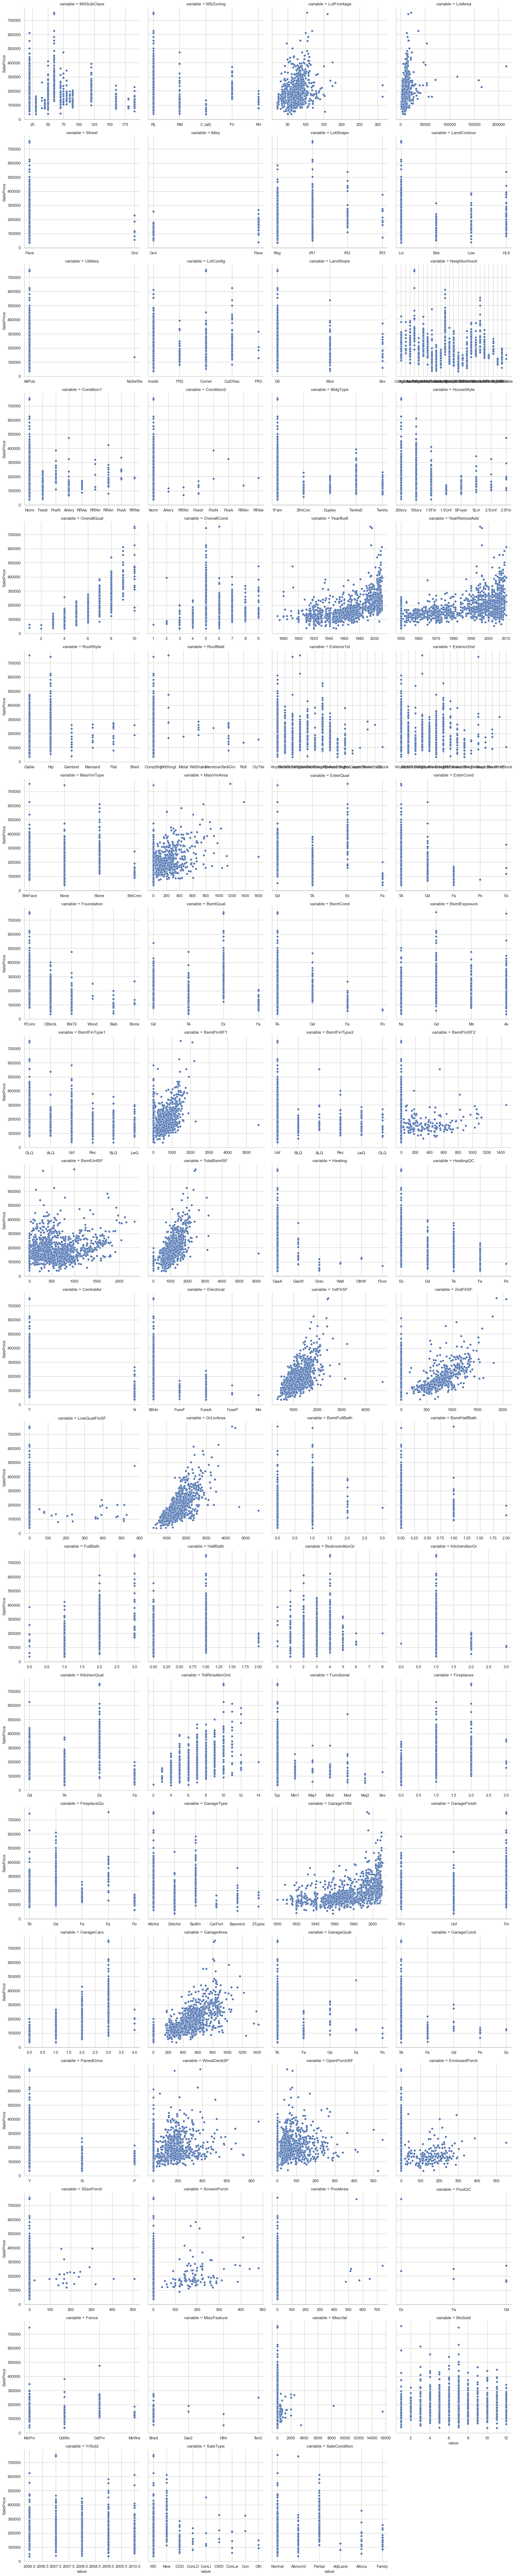

In [19]:
g = sns.relplot(
    data=X.melt(id_vars=['SalePrice']), x='value', y='SalePrice',
    col='variable', col_wrap=4, kind="scatter", facet_kws=dict(sharex=False))



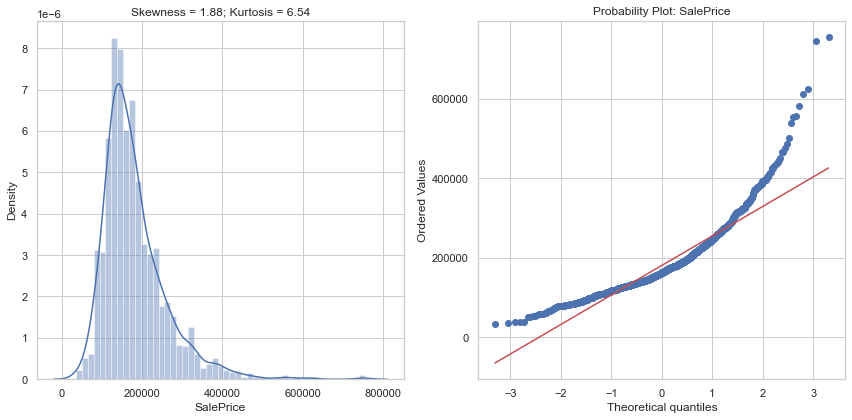

In [36]:
fig, (ax1, ax2) = plotDistribution(X[target])

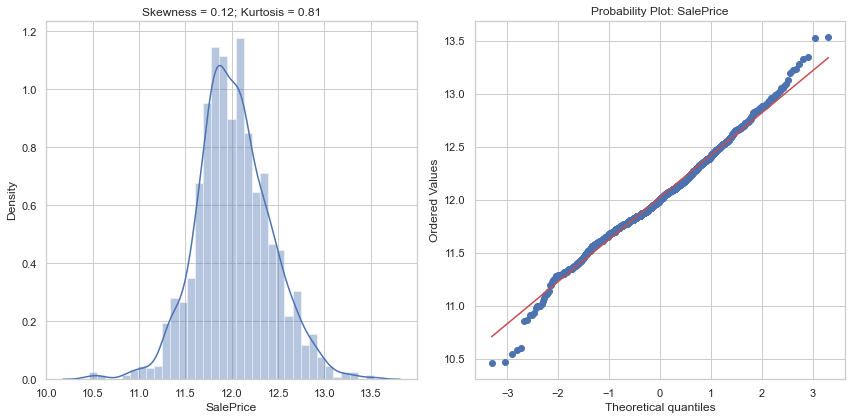

In [37]:
fig, (ax1, ax2) = plotDistribution(np.log(X[target]))

In [38]:
# Processing
X[target] = np.log(X[target])

### Correlation analysis
- Correlate each numerical feature with the predictor.
- Save p-value, N and correlation coefficient for later.

In [39]:
featureCorr = []
for method in ['pearson', pearsonr_pval, countPair]:
    values = X.corr(method=method).stack()
    featureCorr.append(values)
featureCorr = (
    pd.concat(featureCorr, axis=1)
    .reset_index()
    .rename(columns={'level_0': 'feature1', 
                     'level_1': 'feature2', 
                     0: 'R', 1: 'p', 2: 'n'}))
featureCorr['significant'] = featureCorr['p'] < 0.05

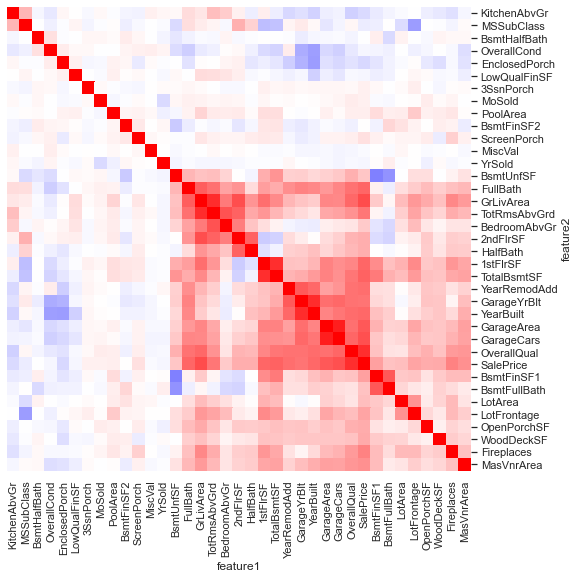

In [40]:
# Convert correlation coefficients to wide format and fill NA (diagonal)
wideCorr = featureCorr.pivot(columns='feature1', index='feature2', values='R')
ax = sns.clustermap(
    wideCorr,
    xticklabels=1, yticklabels=1, 
    row_cluster=True, col_cluster=True,
    cbar_pos=None, cmap='bwr', vmin=-1, vmax=1)
ax.ax_row_dendrogram.set_visible(False)
ax.ax_col_dendrogram.set_visible(False)
plt.tight_layout()

In [41]:
targetCorr = (
    featureCorr.loc[featureCorr['feature1'] == target]
    .set_index('feature2'))
targetCorr = targetCorr.sort_values(by=['R'], ascending=False)

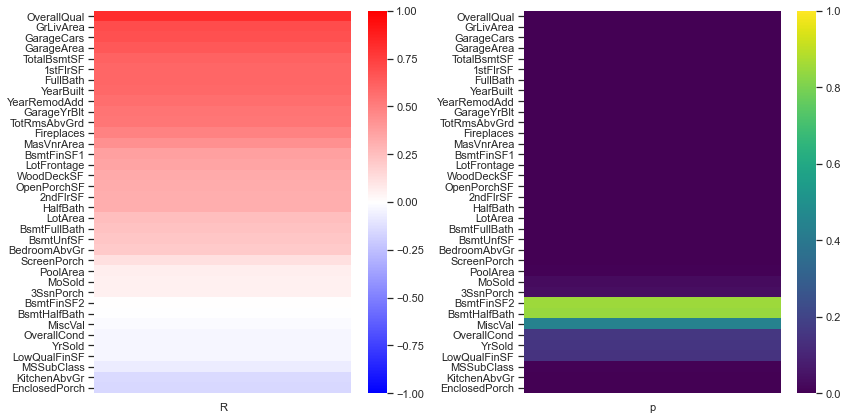

In [42]:
fig, (ax1, ax2) = plotCorrelation(targetCorr)

### Missing data assessment
- Compute NA frequency for each feature

In [51]:
nullOrd = X.isnull().sum().sort_values(ascending=False)
nullOrd = nullOrd[nullOrd > 0]
nullOrd = pd.DataFrame(nullOrd, columns=['TotalNA'])
nullOrd['PropNA'] = nullOrd['TotalNA'] / len(X)
nullOrd

,TotalNA,PropNA
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685


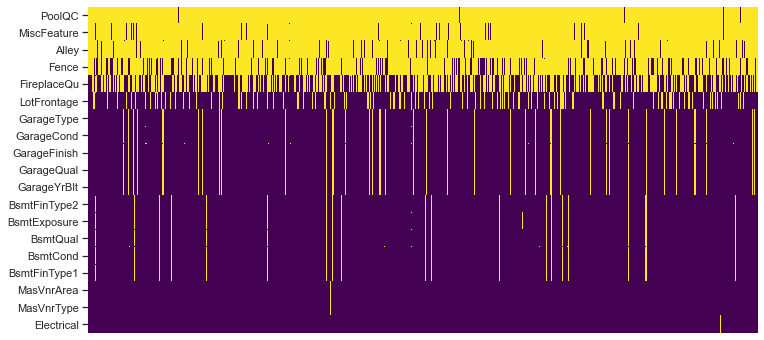

In [44]:
fix, ax = plt.subplots()
sns.heatmap(X[nullOrd.index].isnull().T, yticklabels=1, cmap='viridis', cbar=False, xticklabels=False, ax=ax)
ax.set_xlabel('')
ax.tick_params(left=True)
fig.tight_layout()

## Missing values

### High proportion NA features
- Remove all features with > 15% missing values.
- No strong relationship with SalePrice anyway.

In [49]:
# Processing
X['Alley'] = X['Alley'].fillna('No alley access')
X['BsmtQual'] = X['BsmtQual'].fillna('No Basement')
X['BsmtCond'] = X['BsmtCond'].fillna('No Basement')
X['BsmtExposure'] = X['BsmtExposure'].fillna('No Basement')
X['BsmtFinType1'] = X['BsmtFinType1'].fillna('No Basement')
X['BsmtFinType2'] = X['BsmtFinType2'].fillna('No Basement')
X['BsmtFullBath'] = X['BsmtFullBath'].fillna(0)
X['BsmtHalfBath'] = X['BsmtHalfBath'].fillna(0)
X['BsmtUnfSF'] = X['BsmtUnfSF'].fillna(0)
X['Fence'] = X['Fence'].fillna('No Fence' )
X['FireplaceQu'] = X['FireplaceQu'].fillna('No Fireplace')
X['Fireplaces'] = X['Fireplaces'].fillna(0)
X['MiscFeature'] = X['MiscFeature'].fillna('No misc feature')
X['MiscVal'] = X['MiscVal'].fillna(0)
X['Functional'] = X['Functional'].fillna('Typ')
X['GarageType'] = X['GarageType'].fillna('No garage')
X['GarageFinish'] = X['GarageFinish'].fillna('No garage')
X['GarageQual'] = X['GarageQual'].fillna('No garage')
X['GarageCond'] = X['GarageCond'].fillna('No garage')
X['GarageArea'] = X['GarageArea'].fillna(0)
X['GarageCars'] = X['GarageCars'].fillna(0)
X['PoolQC'] = X['PoolQC'].fillna('No pool')
X['PoolArea'] = X['PoolArea'].fillna(0)

### Save processed
- Remerge features and predictor.
- Ensure to filter predictor by remaining indexes in feature in case rows have been filtered.

In [24]:
X.to_csv('trainFilt.csv')

## Inspecting categoricals

In [264]:
catGroups = X.select_dtypes(exclude=['number'])
catDescribe = catGroups.describe().sort_values(by=['unique'], ascending=False, axis=1).T
catSmallest = catGroups.melt().groupby('variable').apply(lambda x: x.value_counts().min()).rename('smallestGroup')
catDescribe = pd.merge(catDescribe, catSmallest,
                       left_index=True, right_index=True)
catDescribe

,count,unique,top,freq,smallestGroup
Exterior2nd,1460,16,VinylSd,504,1
Exterior1st,1460,15,VinylSd,515,1
Neighborhood,1460,13,other,315,51
SaleType,1460,9,WD,1267,2
Condition1,1460,9,Norm,1260,2
Condition2,1460,8,Norm,1445,1
HouseStyle,1460,8,1Story,726,8
RoofMatl,1460,8,CompShg,1434,1
Functional,1460,7,Typ,1360,1
BsmtFinType2,1422,6,Unf,1256,14


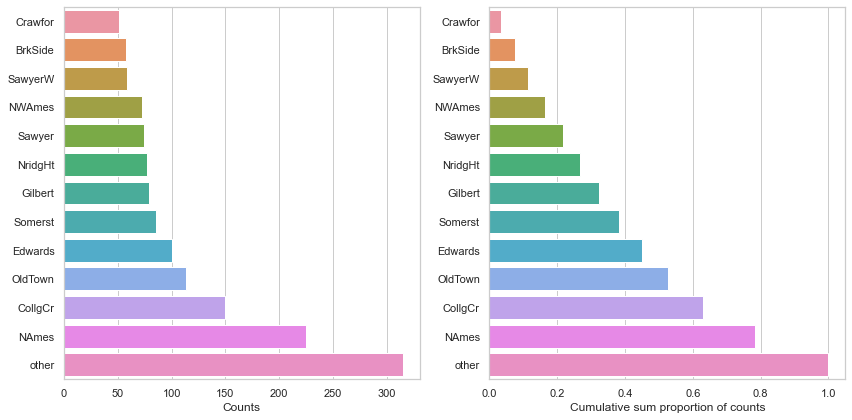

In [246]:
fig, (ax1, ax2) = plt.subplots(1, 2)
counts = X['Neighborhood'].value_counts().sort_values()
countsSum = X['Neighborhood'].value_counts(normalize=True).sort_values().cumsum()
sns.barplot(counts.values, counts.index, ax=ax1)
ax1.set_xlabel('Counts')
sns.barplot(countsSum.values, countsSum.index, ax=ax2)
ax2.set_xlabel('Cumulative sum proportion of counts')
fig.tight_layout()

In [242]:
X['Neighborhood'] = X['Neighborhood'].replace(countsSum[countsSum < 0.25].index, 'other')

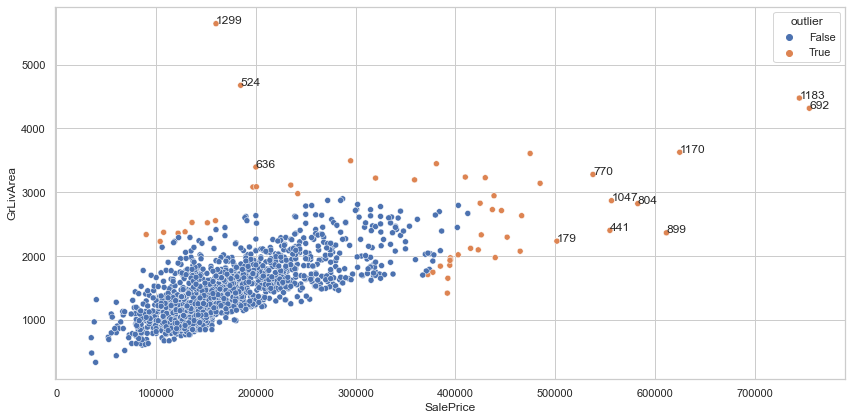

In [820]:
fig, ax = plotBivariateOutlier(x='SalePrice', y='GrLivArea', data=X)

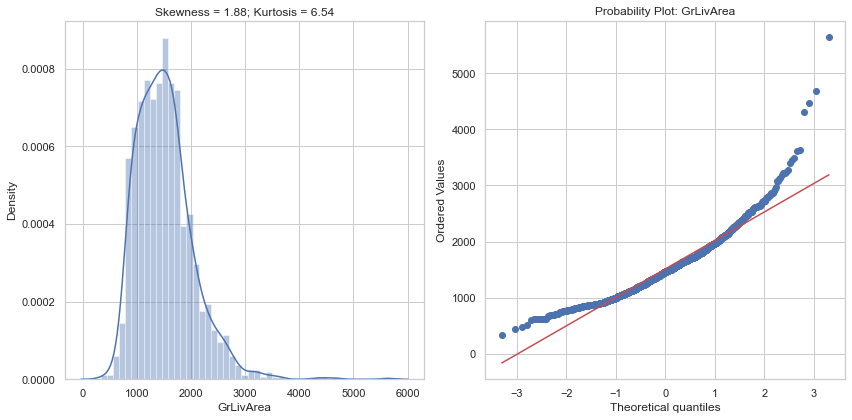

In [830]:
fig, ax = plotDistribution(X['GrLivArea'])

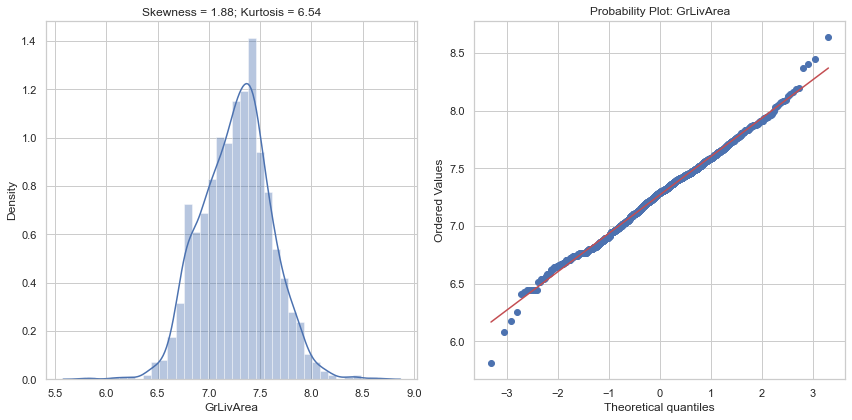

In [831]:
fig, ax = plotDistribution(np.log(X['GrLivArea']))